# Memoria M2

## Imports

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage import io
import matplotlib
from PIL import Image
import pickle

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
# sys.path.append('/content/drive/My Drive/Colab/M2_vision')
# sys.path.append('/content/drive/My Drive/Colab/M2_vision/materialEnviadoVAMaster')
# sys.path.append('/content/drive/My Drive/Colab/M2_vision/materialEnviadoVAMaster/dataset1')
# sys.path.append('/content/drive/My Drive/Colab/M2_vision/materialEnviadoVAMaster/dataset1/grafos_REY_roi_manualSelection1')

In [2]:
from utils_conda import load_point_annotation, load_all_images
from utils_conda import redim_labels, reduce_imgs, adjust_dims, dilate_imgs, plot_annotation, split_train_val_test

## Load annotations

In [3]:
point = 'a1'
df = load_point_annotation(point)
df.head()

Annotations loading complete
Point  a1  dataset size:  (323, 4)


folder                              fname point  \
0   REY_roi_manualSelection1   ROI_0_Psic_119Ev5b.pdf_pg-28.jpg    a1    
5   REY_roi_manualSelection1    ROI_0_Psic_205Ev4.pdf_pg-70.jpg    a1    
10  REY_roi_manualSelection1    ROI_0_Psic_101Ev5.pdf_pg-27.jpg    a1    
15  REY_roi_manualSelection1   ROI_90_Psic_029Ev4.pdf_pg-24.jpg    a1    
20  REY_roi_manualSelection1    ROI_0_Psic_516Ev3.pdf_pg-26.jpg    a1    

   coordinates  
0    (29,445)   
5     (34,24)   
10    (27,41)   
15    (37,33)   
20    (39,41)

## Parameters

In [4]:
img_h,img_w = 900,900
reduct = 0.35
AR_lim = 1.0

## Load images, labels, and graphs

In [5]:
imgs,labels = load_all_images(df)

Number of images added:  307
Number of labels added:  307


### Adjust images size

In [6]:
labels_filtered, imgs_filtered = [],[]
for i,img in enumerate(imgs):
    AR = img.shape[0]/img.shape[1]
    if AR<AR_lim and img.shape[0]<img_h and img.shape[1]<img_w:
        img = adjust_dims(img,img_h,img_w)
        img = dilate_imgs(img)
        img = reduce_imgs(img,reduct=reduct)
        imgs_filtered.append(img)
        labels_filtered.append(labels[i])
print('Number of images (filtered): ',len(imgs_filtered))
print('Number of labels (filtered): ',len(labels_filtered))

Number of images (filtered):  201
Number of labels (filtered):  201


### Sanity check

In [7]:
idx = 25
plt.imshow(imgs_filtered[idx]), plt.show()
print('Image size: ',imgs_filtered[idx].shape)

Image size:  (315, 315, 3)


### Redimensionate labels dataset

In [8]:
y = redim_labels(labels_filtered,point='a1')
y = y*2*reduct/img_h #redim coordinates

Shape of labels dataset:  (201, 2)


### Redimensionate images dataset

In [9]:
X = np.stack(imgs_filtered)
print('Shape of image set: ',X.shape)

Shape of image set:  (201, 315, 315, 3)


### Plot annotation

In [10]:
plot_annotation(X,y*img_h,idx=idx)
print('Coordinates (x,y): ',y[idx]*img_h)

Coordinates (x,y):  [25.9 30.1]


### Split train and test dataset

In [11]:
X_train,X_val,X_test,y_train,y_val,y_test = split_train_val_test(X,y,n=0.2)

Size of training set:   120
Size of validation set:   40
Size of testing set:   41


## Keras Convolutional Neural Network

In [12]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from keras.regularizers import l1, l2

Using TensorFlow backend.


In [13]:
def model_sq(X_,y_):
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3,3), padding='Same', activation='relu', 
                     input_shape=X_.shape[1:]))
    model.add(Conv2D(filters=8, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(y_.shape[-1]))

    model.summary()
    model.compile('adadelta','mse')
    return model

model = model_sq(X,y)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 315, 315, 8)       224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 315, 315, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 157, 157, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 157, 157, 16)      1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 157, 157, 16)      2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 78, 78, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 97344)            

In [ ]:
# Train.
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=2)

### Plot learning curve

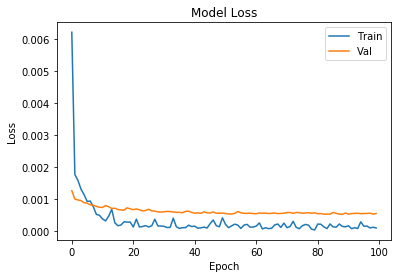

In [17]:
# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim([0.,0.040])
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## Evaluate

### Predict labels

In [16]:
# Predict point coordinates on the test images.
pred_y = model.predict(X_test)
pred_points = pred_y * img_h
pred_points.shape

(41, 2)

### Plot detected points

[22.689268 37.187634]
[23.240784 42.94724 ]
[23.427605 31.57965 ]
[19.91569 33.98473]


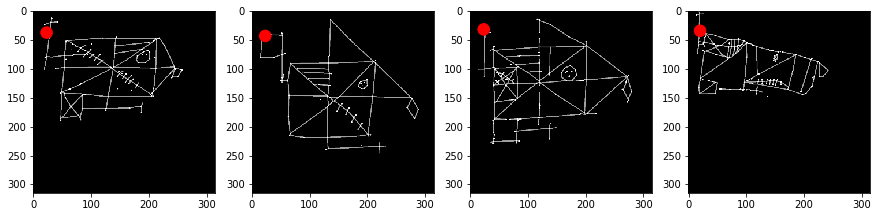

In [17]:
plt.figure(figsize=(15,6))
for i_subplot in range(1, 5):

    i = np.random.randint(len(X_test))
    B = X_test[i]
    a = pred_points[i]
    print(a)
    
    plt.subplot(1, 4, i_subplot)
    plt.imshow(B, cmap='gray', interpolation='none', origin='upper')#, extent=[0,img_w,0,img_h])
    plt.gca().add_patch(plt.Circle((a[0], a[1]), 10, color='r'))

### Evaluate mean squared error

In [18]:
summed_mse = 0
test_points = y_test * img_h
for pred_p, test_p in zip(pred_points, test_points):
    summed_mse += np.sqrt((pred_p[0]-test_p[0])**2 + (pred_p[1]-test_p[1])**2)
mse = summed_mse / len(pred_points)
print('Final error:  ',mse)

Final error:   27.900484955385053


In [16]:
print('Final error:  ',model.evaluate(X_test,y_test))

41/41 [==============================] - 1s 36ms/step
Final error:   0.029041577312277585


### Save model and weights

In [15]:
filename = 'model_a1_2.sav'
pickle.dump(model, open(filename, 'wb'))

In [19]:
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.evaluate(X_test,y_test)

41/41 [==============================] - 6s 141ms/step


0.002183570907019624